# Hands on timeseries analysis
### part12. Backtesting machine learing models for time series forecasting

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.11.09 </div> 
<div style="text-align: right"> Last update: 2020.11.09</div> 

일반적인 회귀, 분류 모델의 검증을 위해 k-fold cross validation이 자주 사용되었다.  
하지만 시계열 데이터에서는 이방법이 사용되지 못한다.  
교차검증에서는 각 샘플간 의존성이 없고 상호 독립이라고 가정한다. 하지만 시계열은 그렇지 않기 때문에 데이터를 시간 순서로 나누어야 한다.  


여기서는 시계열 데이터에 사용될 수 있는 `Train-Test split`, `Multiple Train-Test splits`, `Walk-Forward validation` 세가지의 검증방법을 살펴본다.

### 1. 데이터 준비

`sunspots.csv` : 230년간 측정된 월별 흑점의 수(Monthly Sunspot Dataset)를 기록한 데이터를 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

In [2]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/sunspots.csv'

In [3]:
series = pd.read_csv(url, header=0, index_col=0)

In [4]:
series.head()

,Sunspots
Month,
1749-01,58.0
1749-02,62.6
1749-03,70.0
1749-04,55.7
1749-05,85.0


In [5]:
series.shape

(2820, 1)

시각화

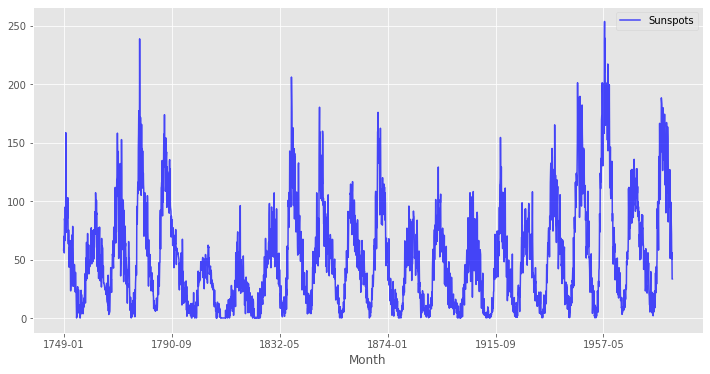

In [6]:
series.plot(figsize = (12, 6), color = 'b', alpha = 0.7)

### 2. Train-Test Split

임의의 포인트(시점)을 기준으로 학습-시험 데이터를 나누는 방법이다.

In [7]:
X = series.values

In [8]:
train_size = int(len(X)*0.66)
train, test = X[: train_size], X[train_size:]

In [9]:
print('전체 샘플수 : {}'.format(len(X)))
print('학습 데이터 : {}'.format(len(train)))
print('시험 데이터 : {}'.format(len(test)))

전체 샘플수 : 2820
학습 데이터 : 1861
시험 데이터 : 959


시각화

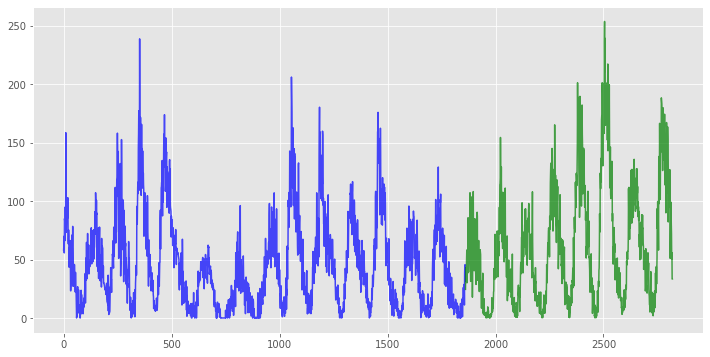

In [10]:
fig, ax = plt.subplots(figsize= (12, 6))
ax = plt.plot(train, color = 'b', alpha = 0.7)
ax = plt.plot([None for i in train]+[x for x in test], color = 'g', alpha = 0.7)
plt.show()

- 간단하고, 단순하고, 직관적이다.  
- 큰 데이터를 다룰 때나, 시험 데이터와 학습 데이터의 성질이 비슷할 때 사용된다.

### 3. Multiple Train-Test Splits

학습-시험 데이터를 여러개로 나누는 방법이다.

학습하고 평가하는 동안 모델을 여러번 만든다. 컴퓨테이션 로드가 발생하지만 강건한 성능평가가 가능하다.  
sklearn에는 TimeSeriesSplit라는 라이브러리를 제공한다.  
여기서는 이 라이브러리를 사용해본다.

In [11]:
from sklearn.model_selection import TimeSeriesSplit

In [12]:
X = series.values
splits = TimeSeriesSplit(n_splits=3)

전체 샘플수 : 1410
학습 데이터 : 705
시험 데이터 : 705
 
전체 샘플수 : 2115
학습 데이터 : 1410
시험 데이터 : 705
 
전체 샘플수 : 2820
학습 데이터 : 2115
시험 데이터 : 705
 


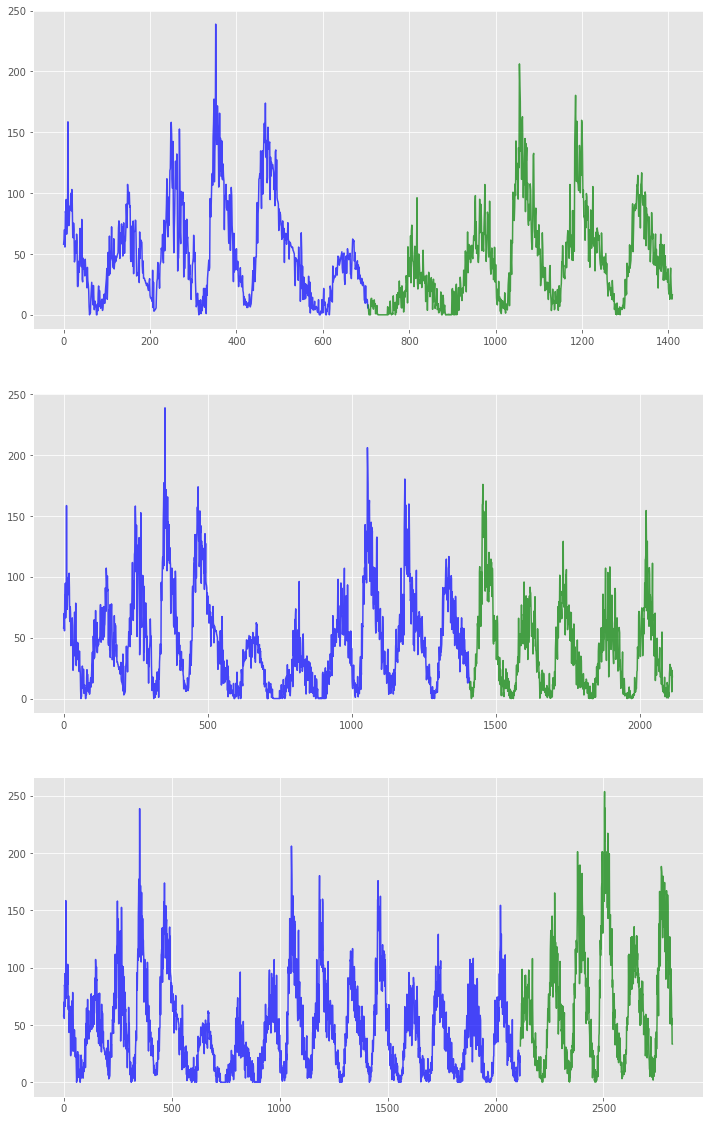

In [13]:
plt.figure(1, figsize = (12, 20))
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('전체 샘플수 : {}'.format(len(train)+len(test)))
    print('학습 데이터 : {}'.format(len(train)))
    print('시험 데이터 : {}'.format(len(test)))
    print(' ')
    plt.subplot(310 + index)
    plt.plot(train, color = 'b', alpha = 0.7)
    plt.plot([None for i in train] + [x for x in test], color = 'g', alpha = 0.7)
    index += 1
plt.show()

- 검증 동안 모델 생성횟수가 늘어나지만, 강건한 검증이 가능해진다.

### 4. Walk Forward Validation

실제 사례에서는 새로운 데이터가 생성되면 모델을 재학습 시키려고 할 것이다.  
이렇게 함으로써 모델이 좋은 예측성능을 보일수가 있을 것이다.  

이 때 몇가지 결정지어야 할 부분이 있다.  
1. 최소 샘플 수 : 모델을 학습시킬 최소한의 샘플수를 지정해야 함. 여기서 윈도우의 개념이 생김  
2. Sliding or Expanding window : 모델이 전체를 대상으로 학습될 것인지, 아니면 최근 데이터로만 학습할 것인지 결정해야함.

이 것이 정해지고 나면 다음과 같은 순서로 모델이 학습, 평가된다.  
1. 처음에 윈도우의 최소 샘플로만 모델을 학습시킨다.  
2. 모델이 다음 스템을 예측한다.  
3. 예측 결과가 저장 또는 평가된다.  
4. 윈도우가 확장되고 1번부터 과정을 반복한다.

위와 같은 이유로 이 방법이 Walk Forward Validation 또는 Rolling Window Forecast라고 불린다.

이 방법은 Scikit-learn에는 탑재되어 있지 않다. TimeSeriesSplit 라이브러리를 잘 설정해서 사용하던지 아니면 직접 구현해서 사용해야 한다.

In [14]:
X = series.values
n_train = 500 # 윈도우 길이
n_records = len(X) # 전체 길이

In [15]:
for i in range(n_train, n_records):
    train, test = X[:i], X[i:i+1]
    print('train = {}, test = {}'.format(len(train), len(test)))

train = 500, test = 1
train = 501, test = 1
train = 502, test = 1
train = 503, test = 1
train = 504, test = 1
train = 505, test = 1
train = 506, test = 1
train = 507, test = 1
train = 508, test = 1
train = 509, test = 1
train = 510, test = 1
train = 511, test = 1
train = 512, test = 1
train = 513, test = 1
train = 514, test = 1
train = 515, test = 1
train = 516, test = 1
train = 517, test = 1
train = 518, test = 1
train = 519, test = 1
train = 520, test = 1
train = 521, test = 1
train = 522, test = 1
train = 523, test = 1
train = 524, test = 1
train = 525, test = 1
train = 526, test = 1
train = 527, test = 1
train = 528, test = 1
train = 529, test = 1
train = 530, test = 1
train = 531, test = 1
train = 532, test = 1
train = 533, test = 1
train = 534, test = 1
train = 535, test = 1
train = 536, test = 1
train = 537, test = 1
train = 538, test = 1
train = 539, test = 1
train = 540, test = 1
train = 541, test = 1
train = 542, test = 1
train = 543, test = 1
train = 544, test = 1
train = 54

- 많은 모델이 만들어져서 검증 신뢰도가 상승한다.  
- 컴퓨테이션 로드를 줄이고 싶다면 스케일을 조정하면 된다.